In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

In [3]:
trainset_sub = Subset(trainset, indices=range(6400))
trainloader = torch.utils.data.DataLoader(trainset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)
testset_sub = Subset(trainset, indices=range(1000))
testloader = torch.utils.data.DataLoader(testset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)

In [4]:
class model_MNIST(nn.Module):
    def __init__(self):
        super(model_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self, batches):
        losses = []
        running_loss = 0.0
        for i, batch in enumerate(batches):
            X_batch, y_batch = batch 
            
            X_batch = X_batch.to()
            y_batch = y_batch.to()
          

            self.optimizer.zero_grad()
            
            y_pred = self.forward(X_batch)
            loss = self.loss_fn(y_pred, y_batch)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            
            #print(i, loss.item())
            if i % 200 == 199:
                print('{} loss: {}'.format(i + 1, 
                                           round(running_loss / 200, 
                                                 3)))
                losses.append(running_loss)
                running_loss = 0.0 
                
        plt.plot(np.arange(len(losses)), losses)
        plt.show()
        print('train ended')
        
    def test(self, data):
        class_correct = list(0 for i in range(10))
        class_total = list(0 for i in range(10))
        classes = np.arange(10)
        
        with torch.no_grad():
            for i, batch in enumerate(data):
                images, labels = batch
                y_pred = self.forward(images)
                _, predicted = torch.max(y_pred, 1)
                
                checker = (predicted.detach() == labels)
                
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += checker[i].item()
                    class_total[label] += 1
                if i == 999:
                    break
                    
        for idx, num_class in enumerate(classes):
            print('Accuracy of {}: {}'.format(num_class, round(class_correct[idx] / class_total[idx] * 100, 3)))
        
        print('Mean accuracy = {}'.format(sum(class_correct) / sum(class_total) * 100))

In [5]:
class mixedPool(nn.Module):
    def __init__(self, kernel_size, stride, alpha = 0.5, padding = 0):
        super(mixedPool, self).__init__()
        alpha = torch.FloatTensor([alpha])
        self.alpha = nn.Parameter(alpha)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
         
    def forward(self, x):
        x = self.alpha * F.max_pool2d(x,
                                      self.kernel_size,
                                      self.stride,
                                      self.padding) + (1 - self.alpha) * F.avg_pool2d(x,
                                                                                      self.kernel_size,
                                                                                      self.stride, 
                                                                                      self.padding)
        return x

In [6]:
class model_MNIST_mixedPool(model_MNIST):
    def __init__(self):
        super(model_MNIST_mixedPool, self).__init__()
        self.pool1 = mixedPool(2, 2)
        self.pool2 = mixedPool(2, 2)

200 loss: 2.29
400 loss: 2.048
600 loss: 1.251
800 loss: 0.84
1000 loss: 0.685
1200 loss: 0.608
1400 loss: 0.541
1600 loss: 0.519


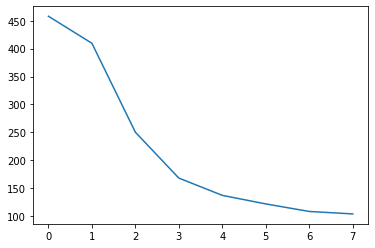

train ended


In [7]:
m3_mixed = model_MNIST_mixedPool()
m3_mixed.train(trainloader)

In [8]:
m3_mixed.test(testloader)

Accuracy of 0: 96.907
Accuracy of 1: 94.828
Accuracy of 2: 79.798
Accuracy of 3: 86.022
Accuracy of 4: 87.619
Accuracy of 5: 71.739
Accuracy of 6: 92.553
Accuracy of 7: 89.744
Accuracy of 8: 70.115
Accuracy of 9: 61.0
Mean accuracy = 83.5
